In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from bmis_emg_utils import * 
from tensorflow_model_optimization.quantization.keras import vitis_quantize

In [2]:
subjects = 6
data, label = get_emg_data(subjects)
print('The total data shape is {} and label is {}'.format(data.shape, label.shape))

The total data shape is (8, 397106) and label is (397106, 1)


In [3]:
data = standardize_data(data, axis=1)

In [4]:
X, y = window_with_overlap(data, label, window_time=200, overlap=70)
print('The total Input data shape after windowing is {} and label is {}'.format(X.shape, y.shape))

The total Input data shape after windowing is (33089, 8, 40) and label is (33089, 1)


In [6]:
X_train, y_train, X_test, y_test = spilt_data(X, y, ratio=0.1)
print('Training Set is{} Test Set {}'.format(X_train.shape, X_test.shape))

Training Set is(29780, 8, 40) Test Set (3309, 8, 40)


In [7]:
# Expanding the input feature shape

X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
print('Expanded Dimension are {}'.format(X_train.shape))
input_size = X_train.shape[1:]
print(input_size)

Expanded Dimension are (29780, 8, 40, 1)
(8, 40, 1)


In [8]:
inputs = tf.keras.Input(shape=input_size)
x = tf.keras.layers.Conv2D(6, 3, activation="relu", input_shape=input_size)(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(151, activation='relu')(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="BMIS-ENG-NET")
model.summary()

2022-05-26 21:19:45.695300: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib
2022-05-26 21:19:45.695353: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-26 21:19:45.695404: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bmis-HP-Pavilion-Notebook): /proc/driver/nvidia/version does not exist
2022-05-26 21:19:45.696048: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlo

Model: "BMIS-ENG-NET"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 40, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 38, 6)          60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 36, 32)         1760      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 18, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 18, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 151)              

In [9]:
lr = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-07, clipnorm=1)
ls = 'sparse_categorical_crossentropy'
mtr = 'accuracy'
n_batches = 15
n_epochs = 10
model.compile(optimizer=opt, loss=ls, metrics=mtr)

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=n_batches, epochs= n_epochs)

2022-05-26 21:20:13.692842: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 38118400 exceeds 10% of free system memory.


Epoch 1/10
1986/1986 [==============================] - 9s 5ms/step - loss: 1.2376 - accuracy: 0.4979 - val_loss: 0.7809 - val_accuracy: 0.6875
Epoch 2/10
1986/1986 [==============================] - 11s 5ms/step - loss: 0.7282 - accuracy: 0.7211 - val_loss: 0.5362 - val_accuracy: 0.7927
Epoch 3/10
1986/1986 [==============================] - 10s 5ms/step - loss: 0.5695 - accuracy: 0.7869 - val_loss: 0.4383 - val_accuracy: 0.8383
Epoch 4/10
1986/1986 [==============================] - 10s 5ms/step - loss: 0.4848 - accuracy: 0.8210 - val_loss: 0.3979 - val_accuracy: 0.8634
Epoch 5/10
1986/1986 [==============================] - 9s 5ms/step - loss: 0.4339 - accuracy: 0.8415 - val_loss: 0.3814 - val_accuracy: 0.8622
Epoch 6/10
1986/1986 [==============================] - 9s 5ms/step - loss: 0.3957 - accuracy: 0.8527 - val_loss: 0.3376 - val_accuracy: 0.8830
Epoch 7/10
1986/1986 [==============================] - 9s 5ms/step - loss: 0.3676 - accuracy: 0.8689 - val_loss: 0.3249 - val_accura

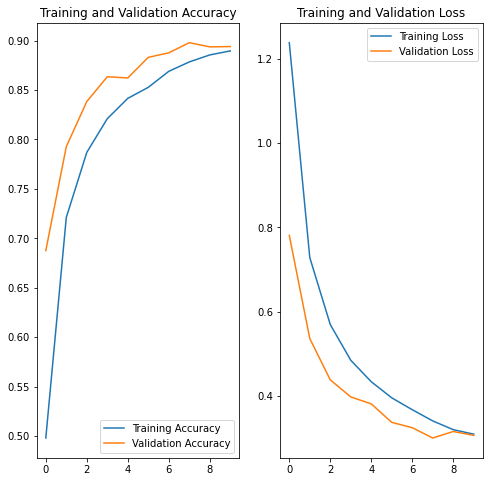

In [12]:
validation_loss = history.history['val_loss']
training_loss = history.history['loss']

validation_accuracy = history.history['val_accuracy']
training_accuracy = history.history['accuracy']

epoch_range = range(n_epochs)
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, training_accuracy, label = "Training Accuracy")
plt.plot(epoch_range, validation_accuracy, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epoch_range, training_loss, label = "Training Loss")
plt.plot(epoch_range, validation_loss, label = "Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [13]:
saved_model = "BMIS-EMG-NET.h5" 
model.save(saved_model)

4. Quantization

In [15]:
calibration_dataset = X_train[0:1000] # Note a minumum of 100 is needed and a maximum of 1000
evaluation_dataset = X_train[1000:]
evaluation_dataset_gnd = y_train[1000:]

In [19]:
saved_float32_model = tf.keras.models.load_model(saved_model)
ptq_quantizer = vitis_quantize.VitisQuantizer(saved_float32_model)
ptq_quantized_model = ptq_quantizer.quantize_model(calib_dataset=calibration_dataset)

[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 1s 63ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
32/32 [==============================] - 1s 17ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quantize Adjustment...
[VAI INFO] Post-Quantize Adjustment Done.
[VAI INFO] Quantization Finished.


In [20]:
# Evalauting Post training quantization

ptq_quantized_model.compile(loss=ls, metrics=mtr)
ptq_quantized_model.evaluate(evaluation_dataset, evaluation_dataset_gnd)

2022-05-26 21:28:51.399676: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 36838400 exceeds 10% of free system memory.


900/900 [==============================] - 3s 3ms/step - loss: 0.1698 - accuracy: 0.9413


[0.16983483731746674, 0.9412786364555359]

In [21]:
# Saving post training quantization

quantized_model = "qunatized_BMIS-EMG-NET.h5"
ptq_quantized_model.save(quantized_model)

5. Compiling

In [22]:
!vai_c_tensorflow2 \
    --model ./qunatized_BMIS-EMG-NET.h5 \
    --arch ./arch.json \
    --output_dir . \
    --net_name model

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./qunatized_BMIS-EMG-NET.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/model_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/quantized-sEMG-Net/code/qunatized_BMIS-EMG-NET.h5
[INFO] keras version: 2.4.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 21/21 [00:00<00:00, 408.81it/s]             
[INFO] dump xmodel: /tmp/model_org.xmodel
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA0_B2304_MAX_BG2
[UNILOG][INFO] Graph name: BMIS-ENG-NET, with op num: 33
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "